In [5]:
from labdaq.utils import *
default_preferences


{'channel_modes': {'cc': {'description': 'current clamp',
   'input_units': 'pA',
   'output_units': 'mV',
   'input_conversion': 0.1,
   'output_conversion': 0.01},
  'vc': {'description': 'voltage clamp',
   'input_units': 'pA',
   'output_units': 'mV',
   'input_conversion': 0.1,
   'output_conversion': 0.01},
  'ttl': {'description': 'TTL digital logic',
   'input_units': 'na',
   'output_units': 'na',
   'input_conversion': 1,
   'output_conversion': 1},
  'analog': {'description': 'regular_output',
   'input_units': 'V',
   'output_units': 'V',
   'input_conversion': 1,
   'output_conversion': 1}},
 'channels': [{'name': 'ephys_in',
   'type': 'analog_input',
   'modes': ['vc', 'cc'],
   'device': 'ni:Dev0',
   'channel': 'ai0',
   'acq_rate': 20000,
   'range': [-10, 10]},
  {'name': 'ephys_out',
   'type': 'analog_output',
   'modes': ['vc', 'cc'],
   'device': 'ni:Dev0',
   'channel': 'ao0',
   'acq_rate': 20000,
   'range': [-10, 10]}]}

In [1]:
import nidaqmx
%matplotlib notebook
import pylab as plt
import numpy as np

import time
class Task():
    def __init__(self, aichan = 'Dev2/ai0', aochan='Dev2/ao0',
                 aiconversion=1000,
                 aoconversion = 0.05,
                 srate = 20000):
        # init tasks
        self.task_ai = None
        self.task_ao = None
        self.task_di = None
        self.task_do = None
        self.srate = srate
        self.aoconversion = np.float32(aoconversion)
        self.aiconversion = np.float32(aiconversion)
        if not aichan is None:
            self.task_ai = nidaqmx.Task()
            self.task_ai.ai_channels.add_ai_voltage_chan(aichan)
            #elf.task_ai.triggers.sync_type.MASTER = True
            #elf.task_ai.control(nidaqmx.constants.TaskMode.TASK_COMMIT)
        if not aochan is None:
            self.task_ao = nidaqmx.Task()
            #f not self.task_ai is None:
            #   self.task_ao.triggers.sync_type.SLAVE = True
            self.task_ao.ao_channels.add_ao_voltage_chan(aochan)        
    def load(self,stim):
        self.nsamples = max(stim.shape)
        if not self.task_ai is None:
            self.task_ai.timing.cfg_samp_clk_timing(rate = self.srate,
                                                    samps_per_chan = self.nsamples)
        if not self.task_ao is None:
            self.task_ao.timing.cfg_samp_clk_timing(rate = self.srate,
                                                    samps_per_chan = self.nsamples)
            self.task_ao.write((stim*self.aoconversion).astype(np.float32), auto_start=False)
        
    def run(self):
        self.task_ai.start()
        self.task_ao.start()

        data=self.task_ai.read(number_of_samples_per_channel = nidaqmx.constants. READ_ALL_AVAILABLE)
        self.task_ai.stop()
        self.task_ao.stop()
        return np.array(data)*self.aiconversion
    
    def close(self):
        self.task_ai.close()
        self.task_ao.close()
task = Task()

# with  as task:
#     task.ao_channels.add_ao_voltage_chan('Dev2/ao0')
#     task.timing.cfg_samp_clk_timing(srate)
#     print('1 Channel N Samples Write: ')
#     print(task.write(pulse.astype(np.float32), auto_start=True))
#     time.sleep(1)
#     task.stop()
    

<IPython.core.display.Javascript object>


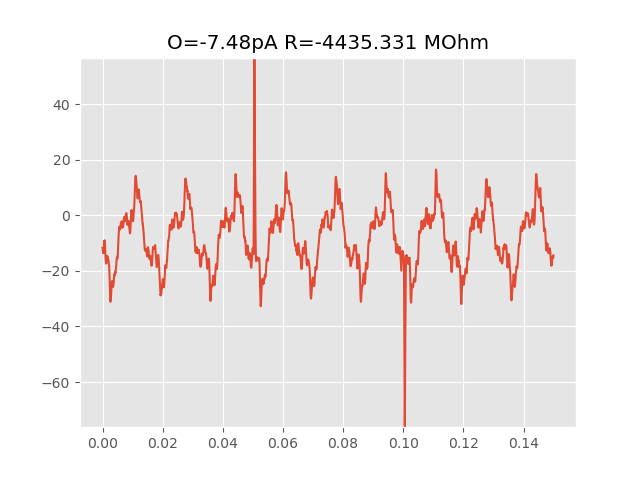

In [25]:
from ipywidgets import (interact, interactive, fixed, interact_manual)
from ipywidgets import (Select, Textarea, Button,Dropdown, VBox,
                        HBox, Layout, Label, Text,Play,jslink)
from IPython.display import display
from ipywidgets import Play,jslink,HBox

from matplotlib.animation import FuncAnimation
plt.matplotlib.style.use('ggplot')
def nbSealTest(task,interval=500,amp=5,**kwargs):
    srate = task.srate
    pulse = np.hstack([np.zeros(int(0.05*srate)),amp*np.ones(int(0.05*srate)),np.zeros(int(0.05*srate))])    
    time = np.arange(len(pulse))/srate
    fig = plt.gcf()
    im = plt.plot(time,pulse,**kwargs)[0]
    
    def animate(change):
        task.load(pulse)
        data = task.run()
        dd = np.array(data)
        im.set_ydata(dd)
        Ipre = np.mean(dd[(time<0.03)])
        Istim = np.mean(dd[(time>0.06
                           
                           ) & (time<0.09)])
        R = (amp*1e-3/((Istim-Ipre)*1e-12))/1e6
        plt.title('O={0:.2f}pA R={1:.3f} MOhm'.format(Ipre,R))
        plt.ylim([np.min(dd),np.max(dd)])
    anim = FuncAnimation(fig, animate, interval=interval)
    return dict(fig = plt.gcf(),ax=plt.gca(),im= im,anim = anim)
plt.figure()
anim = nbSealTest(task)


In [31]:
plt.axis('tight')

(-0.011997500000000001, 0.2519475, -1.05, 0.05)

<IPython.core.display.Javascript object>


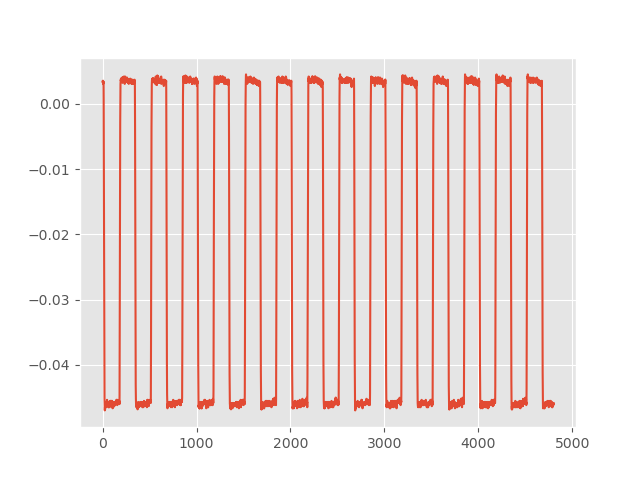

In [8]:
values= task.run()
plt.plot(values)

In [17]:
((5e-3/10e6)*1e12 )/(np.max(values)-np.min(values))



9710.160377419787